In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set() #sets the matplotlib style to seaborn style

from scipy.io import loadmat 
from scipy.ndimage import convolve1d
from scipy.signal import butter
from scipy.signal import sosfiltfilt
from scipy.signal import filtfilt
from scipy.signal import welch
import pandas as pd

import sys
sys.path.append('/Users/loufourneaux/Desktop/EPFL/MA3/NSSP/project_2_nssp')

from utils import *  

# 1 - Load data and understand composition

In [2]:
file_name= '/Users/loufourneaux/Desktop/EPFL/MA3/NSSP/project_2_nssp/S2_A1_E1.mat'
emg=loadmat(file_name)

# List all variables in the .mat file
print(emg.keys())

#the actual interesting data lives in the columns ['emg', 'restimulus', 'rerepetition']
emg_rectified = emg["emg"].copy()

#Restimulus and rerepetition are the stimulus and repetition that have been processed for better correspondance to real movement
#Stimulus is the type of movement that is being performed
stimulus = emg["restimulus"] 
#Repetition is the number of times the movement has been repeated
repetition = emg["repetition"] 

print(f'What are the shape of the data that we are working with? \nEMG: {emg_rectified.shape}, \nStimulus {stimulus.shape}, \nRepetition {repetition.shape}')

dict_keys(['__header__', '__version__', '__globals__', 'subject', 'exercise', 'stimulus', 'emg', 'glove', 'restimulus', 'repetition', 'rerepetition'])
What are the shape of the data that we are working with? 
EMG: (100686, 10), 
Stimulus (100686, 1), 
Repetition (100686, 1)


### Exploration of the data
There are measures at 100686 time points from 10 channels (probably 10 electrodes). See below that there are 12 types of movement performed and they are repeated 10 times. The number of samples for each trial is different because of the nature of each exercise.
The data is partially preprocessed

In [3]:
# -1 because 0 is the resting condition
n_stimuli = len(np.unique(stimulus)) - 1 
# -1 because 0 is not a repetition
n_repetitions = len(np.unique(repetition)) - 1 
n_channels = emg_rectified.shape[1]

print(f'How many types of movement are there? {n_stimuli}') 
print(f'How many repetitions are there? {n_repetitions}')


How many types of movement are there? 12
How many repetitions are there? 10


In [4]:
number_of_samples_per_trial = np.zeros((n_stimuli, n_repetitions))

for stimuli_idx in range(n_stimuli):
    for repetition_idx in range(n_repetitions):
        
        idx = np.logical_and(stimulus == stimuli_idx+1, repetition == repetition_idx+1)
        number_of_samples_per_trial[stimuli_idx, repetition_idx] = np.sum(idx.astype(int))

number_of_samples_per_trial

array([[307., 390., 262., 226., 418., 204., 196., 270., 306., 470.],
       [334., 323., 344., 309., 333., 376., 362., 307., 348., 339.],
       [377., 352., 450., 456., 382., 389., 323., 343., 383., 316.],
       [310., 402., 357., 396., 255., 333., 263., 369., 438., 405.],
       [427., 382., 425., 379., 463., 411., 387., 343., 286., 377.],
       [337., 319., 337., 368., 338., 336., 268., 354., 319., 313.],
       [414., 392., 341., 393., 421., 445., 342., 328., 329., 358.],
       [289., 372., 406., 397., 421., 336., 415., 328., 406., 405.],
       [384., 356., 371., 316., 280., 314., 342., 284., 307., 421.],
       [280., 296., 299., 296., 301., 246., 213., 317., 411., 221.],
       [352., 403., 338., 416., 330., 355., 313., 322., 329., 219.],
       [270., 330., 300., 387., 295., 204., 363., 267., 281., 329.]])

Text(0, 0.5, 'Amplitude')

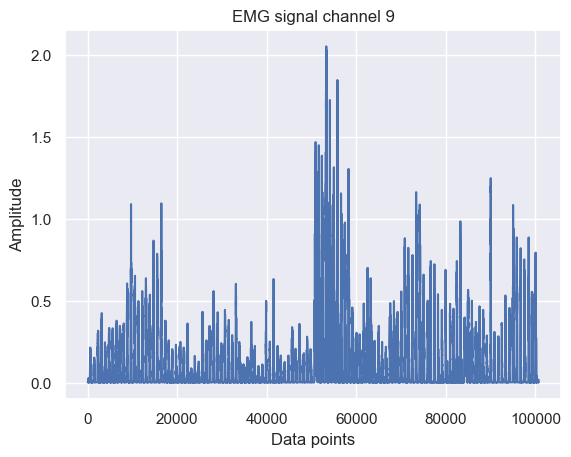

In [5]:
#visualize the data
plt.close("all")
fig, ax = plt.subplots()
EMG_channel = 9
ax.plot(emg_rectified[:, EMG_channel])   
ax.set_title(f"EMG signal channel {EMG_channel}")
ax.set_xlabel("Data points")
ax.set_ylabel("Amplitude")

### Window and envelope
Now, lets visualize the data. In this example, we will illustrate using data from a single trial (repetition 1 of stimulus 1) using moving average for detecting the envelope.
If plot emg_windows[0][0]: will see 1rst trial and 1rst repetition

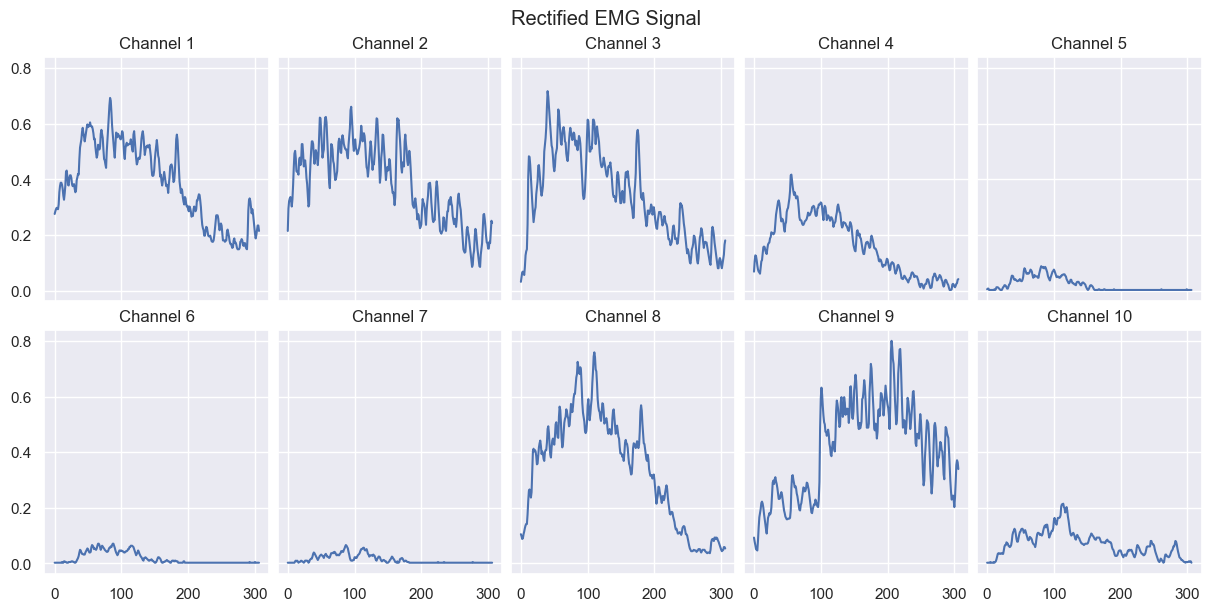

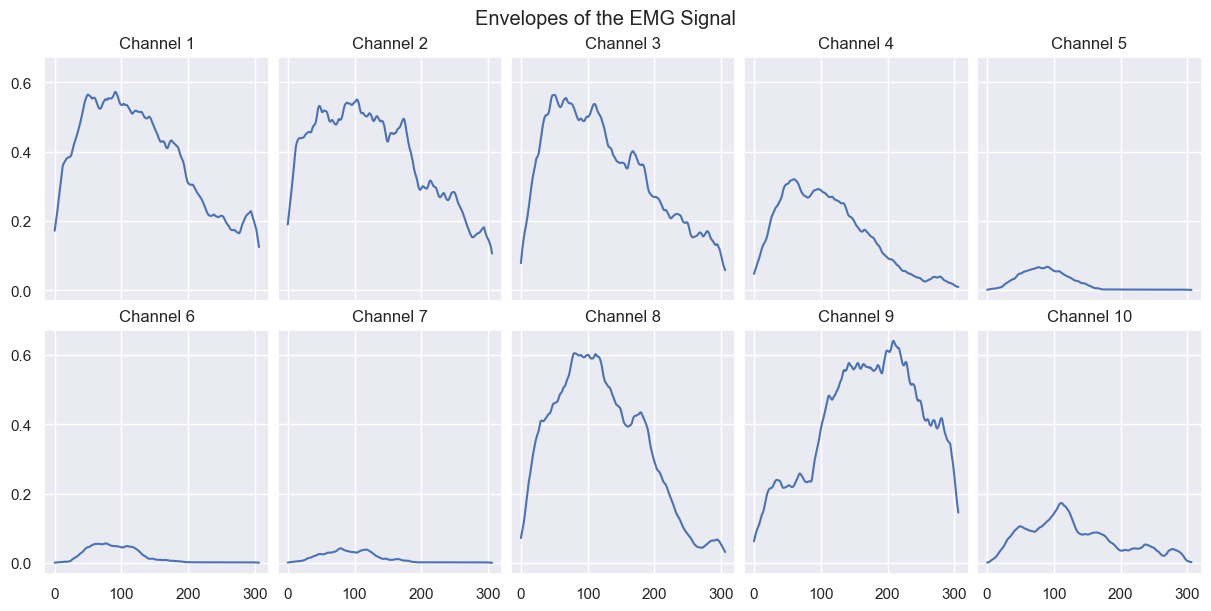

In [5]:

# Example usage (replace these variables with your data):
emg_envelopes = process_and_plot_emg(emg_rectified, stimulus, repetition, n_stimuli, n_repetitions)



### Visualizing across repetitions

Remember that we were only looking at a single trial in the previous section. 

To check for the robustness of the signal, we will generally need to repeat the stimulus multiple times and look at the trend of the signal quality over time.

In [6]:
emg_average_activations = np.zeros((n_channels, n_stimuli, n_repetitions))
for stimuli_idx in range(n_stimuli):
    for repetition_idx in range(n_repetitions):
        #mean across time for each channel
        emg_average_activations[:, stimuli_idx, repetition_idx] = np.mean(emg_envelopes[stimuli_idx][repetition_idx], axis=0) 

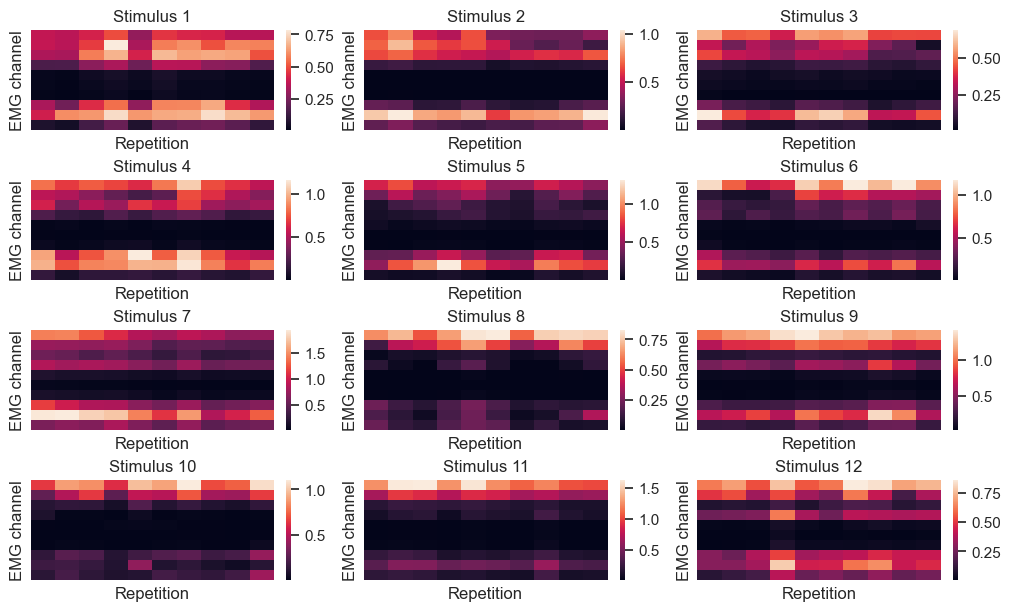

In [8]:
fig, ax = plt.subplots(4, 3, figsize=(10, 6), constrained_layout=True, sharex=True, sharey=True)
ax = ax.ravel()

for stimuli_idx in range(n_stimuli):
    sns.heatmap(np.squeeze(emg_average_activations[:, stimuli_idx, :]), ax=ax[stimuli_idx] ,xticklabels=False, yticklabels=False, cbar = True)
    ax[stimuli_idx].title.set_text("Stimulus " + str(stimuli_idx + 1))
    ax[stimuli_idx].set_xlabel("Repetition")
    ax[stimuli_idx].set_ylabel("EMG channel")

1) The rows capture each channel per stimulus. There is a high homogeneity. Each channel is exposed to the same exercise so they record similar muscle acitivity across repetitions. That's good. 

2) There is some variation in amplitude across repetitions which is normal because it is nerver done in the exact same manner. 

3) Different stimulus seem to activate different muscles. If we normalize the signals it could make them more comparabel across stimuli

### Visualize the frequency components

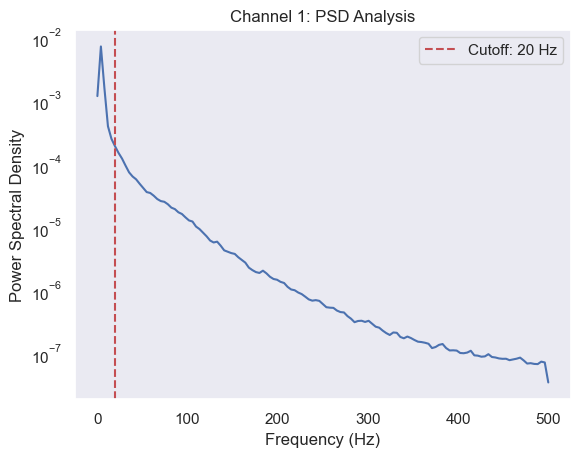

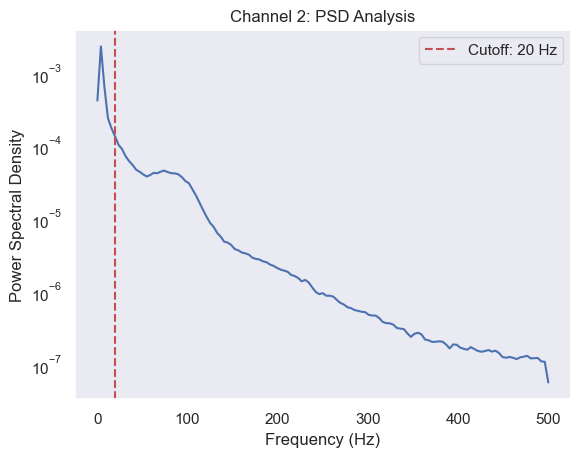

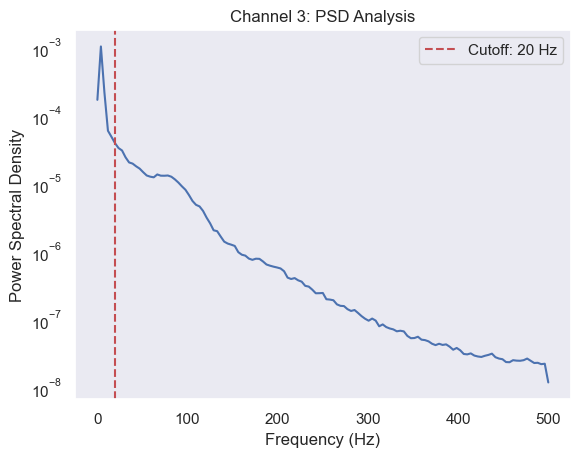

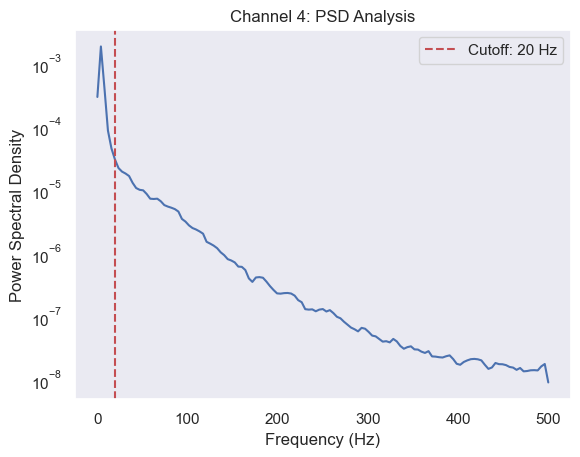

KeyboardInterrupt: 

In [9]:

lfpr = analyze_psd(emg_rectified, fs=1000, cutoff=20)
print(f"Low-Frequency Power Ratio (LFPR) per channel: {lfpr}")

# Decision: If LFPR > 0.2 (20% of total power) for most channels, a high-pass filter is recommended.
if np.any(lfpr > 0.2):
    print("Low-frequency artifacts detected. A high-pass filter is recommended.")
else:
    print("No significant low-frequency artifacts detected.")


### Filtering is needed so high-pass filter and visualize the change

### RUN THE FOLLOWING TO APPLY HIGH PASS FILTER on emg data


In [7]:
emg_highpassed = np.zeros_like(emg_rectified)  # Same shape as original dataset
# Filter the entire dataset along time axis for each channel
for channel_idx in range(emg_rectified.shape[1]):
    emg_highpassed[:, channel_idx] = high_pass_filter(emg_rectified[:, channel_idx], cutoff=20, fs=1000)
    

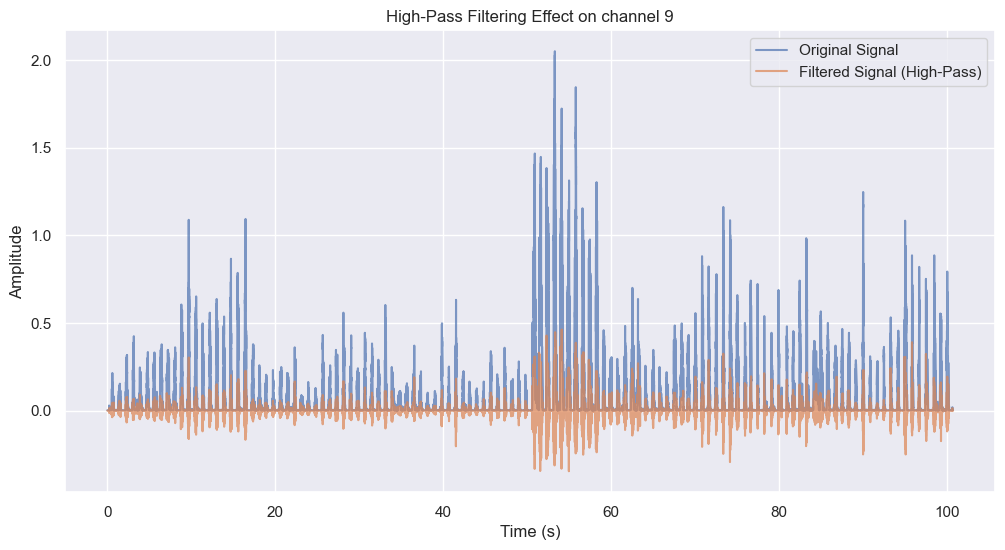

In [19]:
# Plot an example channel before and after filtering
channel_idx = 9
time = np.linspace(0, emg_rectified.shape[0] / 1000, emg_rectified.shape[0])  # Time axis assuming fs = 1000 Hz

plt.figure(figsize=(12, 6))
plt.plot(time, emg_rectified[:, channel_idx], label="Original Signal", alpha=0.7)
plt.plot(time, emg_highpassed[:, channel_idx], label="Filtered Signal (High-Pass)", alpha=0.7)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.title("High-Pass Filtering Effect on channel 9")
plt.show()

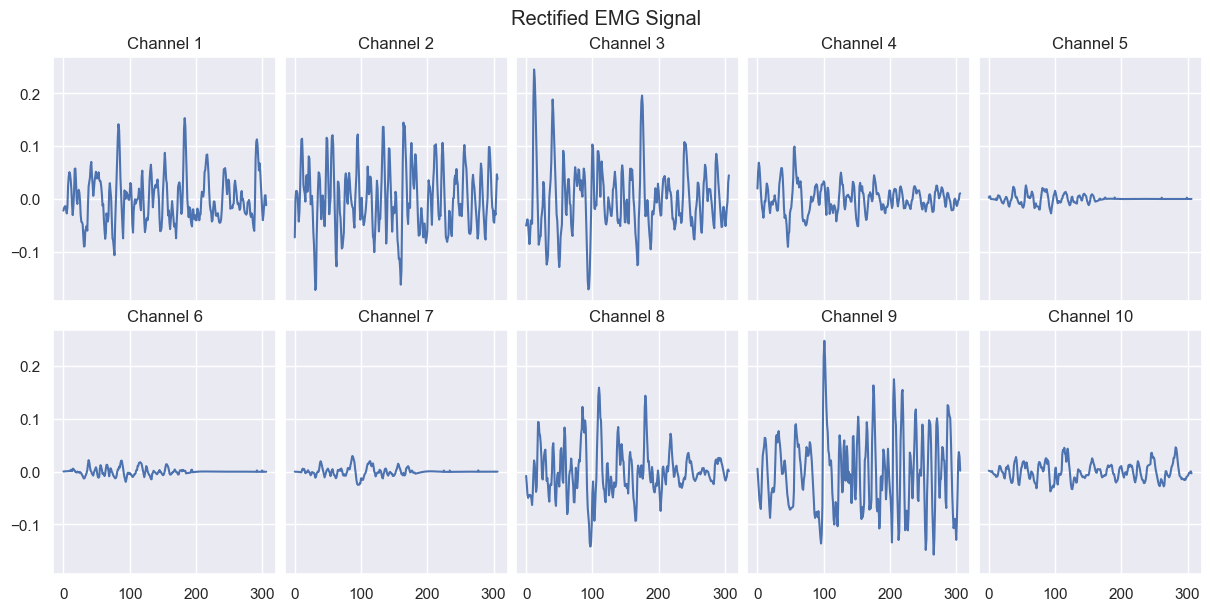

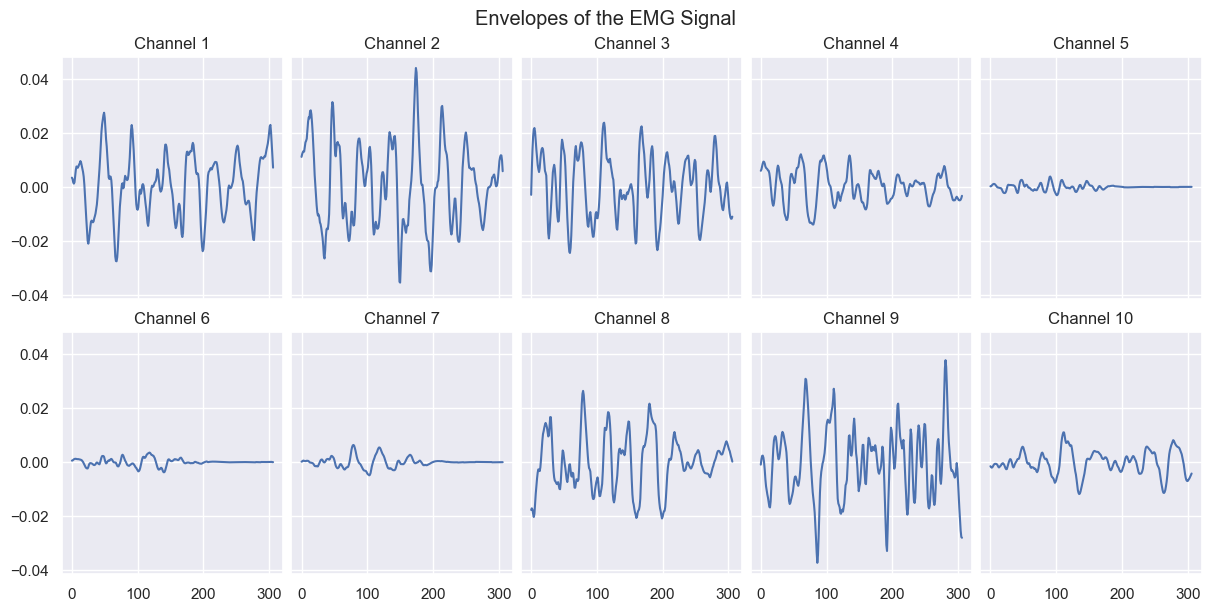

In [20]:
# Example usage (replace these variables with your data):
emg_envelopes_highpassed= process_and_plot_emg(emg_highpassed, stimulus, repetition, n_stimuli, n_repetitions)

# 2 - Extract features for classification

In [8]:
# Define the features 

# Mean absolute value (MAV)
mav = lambda x: np.mean(np.abs(x), axis=0)
# Standard Deviation (STD)
std = lambda x: np.std(x, axis=0)

# Maximum absolute Value (MaxAV)
maxav = lambda x: np.max(np.abs(x), axis=0)

# Root mean square (RMS)
rms = lambda x: np.sqrt(np.mean(x**2, axis=0))

# Waveform length (WL)
wl = lambda x: np.sum(np.abs(np.diff(x, axis=0)), axis=0)

# # Slope sign changes (SSC)
# It counts the number of times the slope changes direction.
ssc = lambda x: np.sum(
    (np.diff(np.sign(np.diff(x, axis=0)), axis=0) != 0).astype(int),
    axis=0
)

# Frequency-domain features
def psd_mean(x, fs=1000):
    freqs, psd = welch(x, fs=fs, axis=0)
    return np.mean(psd, axis=0)

def mean_frequency(x, fs=1000):
    freqs, psd = welch(x, fs=fs, axis=0)
    return np.sum(freqs[:, None] * psd, axis=0) / np.sum(psd, axis=0)




In [9]:
#build the original dataset
dataset, labels =build_dataset_from_ninapro(
        emg=emg_rectified,
        stimulus=stimulus,
        repetition=repetition,
        features=[mav ,std, maxav, rms, wl, ssc]  # Using MAV as the feature
    )

print(dataset.shape)
print(labels.shape)

(120, 60)
(120,)


# Filter the dataset

In [14]:
#REMOVE FLATLINE CHANNELS
n_features_per_channel = 6  # Number of features per channel ssc, wl, ...
filtered_dataset, adjusted_labels, retained_channels = filter_low_mav_channels_multifeature(dataset, labels, n_features_per_channel)

print("Retained Channels:", retained_channels)
print("Filtered Dataset Shape:", filtered_dataset.shape)
print(adjusted_labels.shape)


Retained Channels: [0, 1, 2, 3, 7, 8, 9]
Filtered Dataset Shape: (120, 42)
(120,)


In [11]:
#CREATE HIGHPASSED DATASET
#build the original dataset
dataset_highpassed, labels_highpassed =build_dataset_from_ninapro(
        emg=emg_highpassed,
        stimulus=stimulus,
        repetition=repetition,
        features=[mav ,std, maxav, rms, wl, ssc]  # Using MAV as the feature
    )

print(dataset_highpassed.shape)
print(labels_highpassed.shape)

(120, 60)
(120,)


In [15]:
#FILTERED AND HIGHPASSED DATASET
filtered_dataset_highpassed, adjusted_labels_highpassed, retained_channels_highpassed = filter_low_mav_channels_multifeature(dataset_highpassed, labels_highpassed, n_features_per_channel)

print("Retained Channels:", retained_channels_highpassed)
print("Filtered Dataset Shape:", filtered_dataset_highpassed.shape)
print(adjusted_labels_highpassed.shape)

Retained Channels: [0, 1, 2, 3, 7, 8, 9]
Filtered Dataset Shape: (120, 42)
(120,)


### What do you see? Are the values similar between repetitions and between channels? Explain the possible reasons for similarity/discrepancies.
See that the features are similar across repetitions but with variablity and different across channels. Muscles being activated differently or similarly/electrode impedance... 

/!\ channels 5,6,7 always seem to have very low values so might not be very interesting msucles or electrodes. 

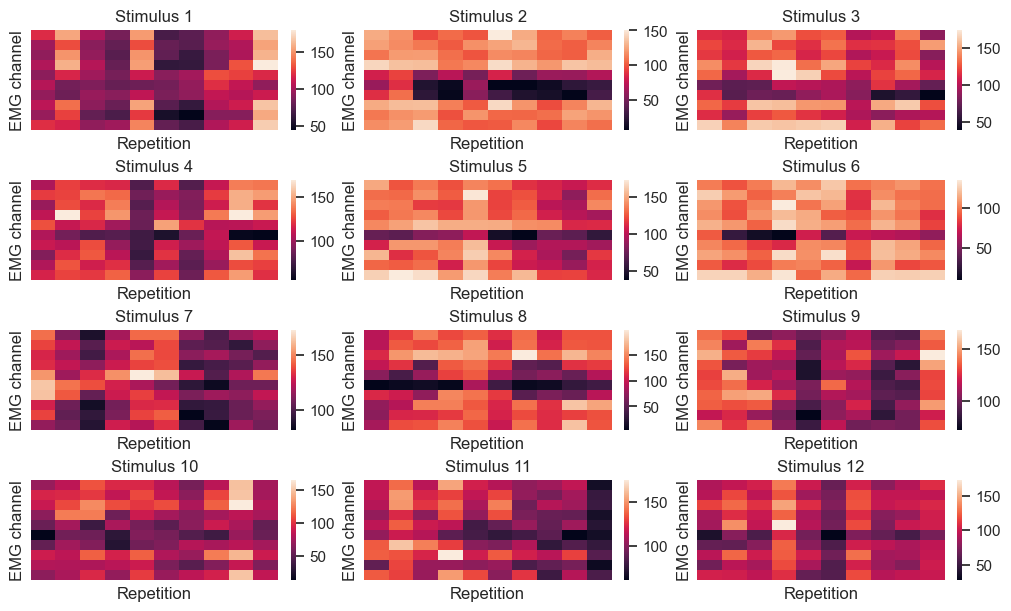

In [13]:

#features are mav ,std, maxav, rms, wl, ssc
analyze_feature(dataset, labels, n_stimuli, n_repetitions, 'ssc')


# 3 - Classifier SVM

Accuracy score: 0.9444444444444444


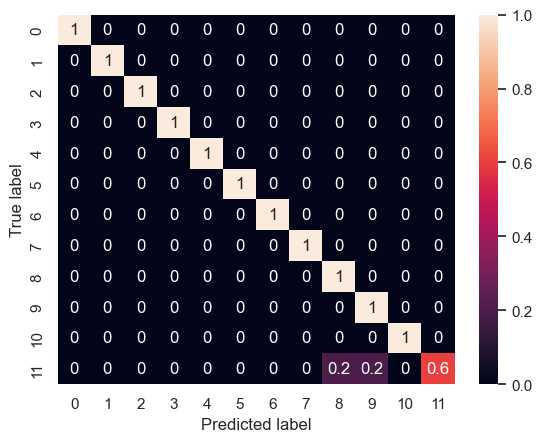

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC  # Import Support Vector Classifier (SVM)
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# Split the dataset into training and testing sets
# Here, 30% of the data is reserved for testing, and 70% is used for training
X_train, X_test, y_train, y_test = train_test_split(dataset, labels, test_size=0.3, random_state=34)

# Normalizing the data bc SVM uses distance metric so it is very sensitive to scale. 
scaler = StandardScaler()
X_train_z = scaler.fit_transform(X_train)  # Fit the scaler on the training data and transform it
X_test_z = scaler.transform(X_test)        # Transform the test data using the same scaler

# We are using Support Vector Machine (SVM) 
clf = SVC(kernel='linear')  #linear seems to work best
clf.fit(X_train_z, y_train)  

# Evaluate the classifier on the test set
y_pred = clf.predict(X_test_z)
# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy score: {accuracy}")

# Create a confusion matrix to visualize the performance of the classification
confmat = confusion_matrix(y_test, y_pred, normalize="true")
fig, ax = plt.subplots()
sns.heatmap(confmat, annot=True, ax=ax)  # Use seaborn to create a heatmap of the confusion matrix
ax.set_ylabel("True label")
ax.set_xlabel("Predicted label")
plt.show()


### Cross-validation

In [30]:
from sklearn.model_selection import cross_val_score
X_scaled = scaler.fit_transform(dataset)  # Scale the entire dataset

# Initialize the SVM classifier
clf = SVC(kernel='linear')  # Use a linear kernel, or you can try 'rbf', 'poly', etc.

# Perform cross-validation
# Here, we use 5-fold cross-validation (cv=5)
scores = cross_val_score(clf, X_scaled, labels, cv=5)  # The classifier, data, labels, and number of splits

# Print the accuracy scores for each fold
print(f"Accuracy scores of all models: {scores}")

# Print the mean accuracy across all folds
print(f"Mean accuracy across all models: {np.mean(scores)}")


Accuracy scores of all models: [0.91666667 0.91666667 0.875      0.95833333 0.875     ]
Mean accuracy across all models: 0.9083333333333332


### Hyperparameter optimization

In [31]:
from sklearn.model_selection import GridSearchCV

# Define the hyperparameter grid for the SVC model
param_grid = {
    "C": [0.1, 1, 10, 100],  # Regularization parameter
    "kernel": ['linear', 'rbf', 'poly'],  # Types of kernels to try
    "gamma": ['scale', 'auto', 0.01, 0.1, 1]  # Kernel coefficient
}

# Initialize the SVC model
svc = SVC()

# Set up GridSearchCV for hyperparameter tuning
grid = GridSearchCV(svc, param_grid, cv=5, scoring='accuracy')  # 5-fold cross-validation

# Fit the model using the training data
grid.fit(X_train_z, y_train)  # Use the scaled training data

# Print the best estimator and the best hyperparameters found by the grid search
print(f"Best estimator: {grid.best_estimator_}")
print(f"Best hyperparameters: {grid.best_params_}")

# Predict the labels for the test data using the best model
y_pred = grid.predict(X_test_z)

# Calculate the accuracy of the best model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy score of best model: {accuracy}")


Best estimator: SVC(C=1)
Best hyperparameters: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Accuracy score of best model: 0.9166666666666666


###Better accuracies:  dataset == filtered_dataset > filtered_dataset_highpassed